In [2]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)


import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import concatenate
import plot
import progressbar as pb
import bootstrap as boot
import regression as reg

In [6]:
criticals =  {
    "beta_c" : 0.5*np.log(1+np.sqrt(2)),
    "nu" : 1.0,
    "gamma" : 7/4,
    "beta" : 1/8 
}

Ns_lst = [20, 40, 60, 80, 100, 120, 140, 160]

beta_lst = [0.42 + j*0.00085 for j in range(48)]

path = f'/home/negro/projects/misc/Ising'

In [7]:
def readfile(path, filename):
    output = np.loadtxt(f'{path}/{filename}', skiprows=1)
    columns = [output[:, i] for i in range(output.shape[1])]
    
    return np.column_stack(columns)

## Average magnetization    

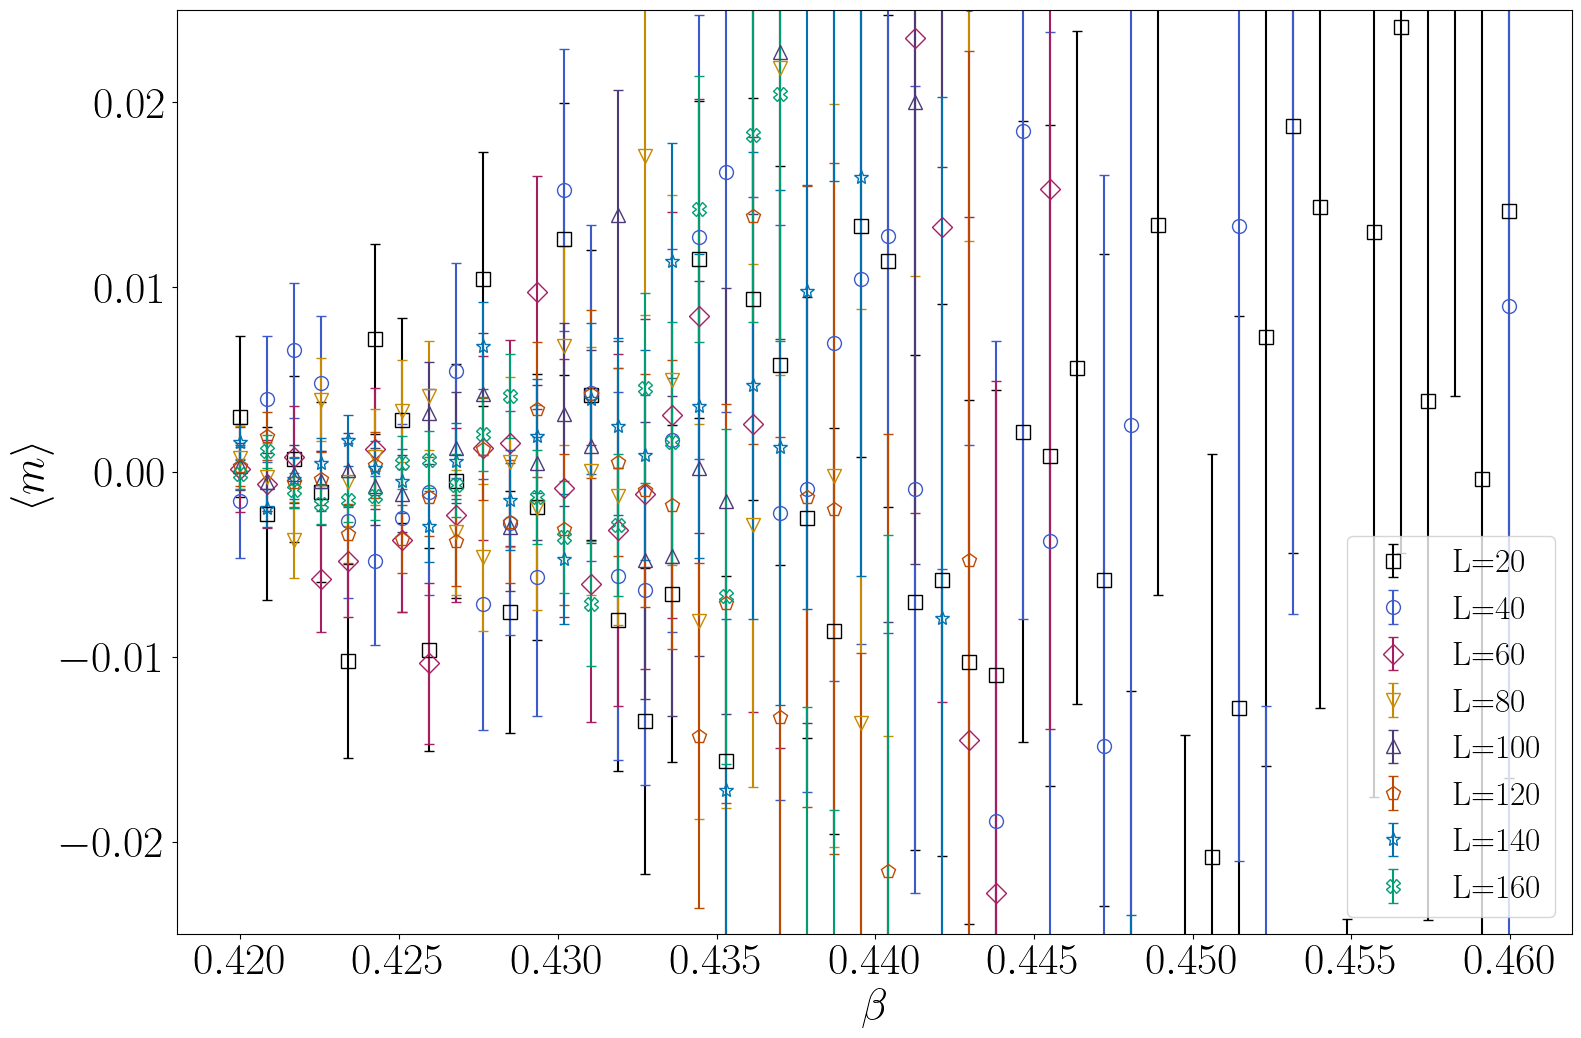

In [8]:
plt.figure(figsize=(18,12))

for i, Ns in enumerate(Ns_lst):
    data = [
        np.load(f'{path}/L{Ns}/avgmag/avgmag_b{beta:.6f}.npy', allow_pickle=True)
        for beta in beta_lst
    ]

    x, y, d_y, b_y = map(list, zip(*data))
    plt.errorbar(x,y,d_y, **plot.data(i), label=f'L={Ns}')
    
plt.ylim(-0.025, 0.025)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

plt.xlabel(r'$\beta$', fontsize=32)
plt.ylabel(r'$\langle m \rangle$', fontsize=32)

plt.legend()

plt.savefig(f"{path}/avg_mag.png", bbox_inches='tight', dpi=300)
plt.show()


In [11]:
beta = 0.42
Ns = 60


x, y, d_y = np.load(f'{path}/L{Ns}/therm/bsa_mag_b{beta:.6f}.npy', allow_pickle=True)

plt.figure(figsize=(18,12))

plt.errorbar(x, y, d_y,
                fmt='o-', capsize=3, 
                markersize=2, linewidth=0.375,
                color=plot.color_dict[1])    

plt.xlabel(r'$K$',fontsize=32)
plt.ylabel(r'$\overline{\sigma}_{\overline{F^{(K)}}}$', fontsize=32)

plt.title("Standard error as a function of the blocksize.")

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

plt.grid(True, which='both', linestyle='--', linewidth=0.25)

plt.savefig(f'{path}/L{Ns}/bsa/bsa_mag_b{beta:.6f}.png', bbox_inches='tight', dpi=300)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/negro/projects/misc/Ising/L60/therm/bsa_mag_b0.420000.npy'

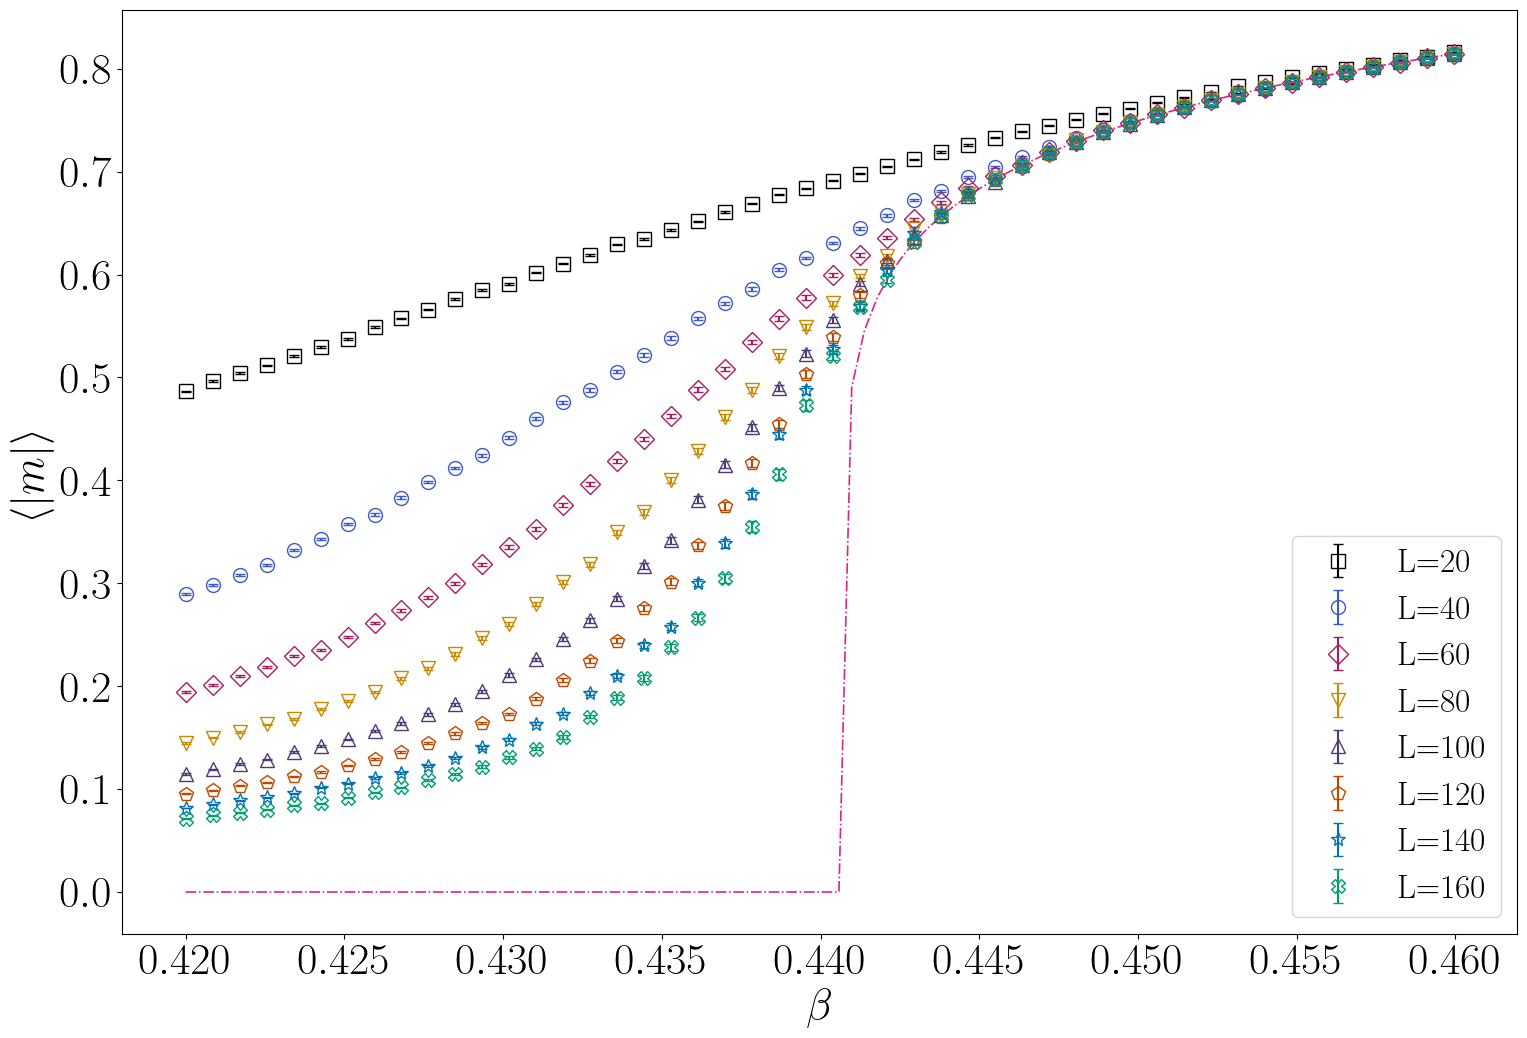

In [16]:
def m0beta(x):
    x = np.asarray(x)
    threshold = 0.5 * np.log(1 + 2**0.5)
    result = np.zeros_like(x)
    
    valid_mask = x >= threshold
    result[valid_mask] = (1 - np.sinh(2 * x[valid_mask])**(-4))**(1/8)
    
    return result

plt.figure(figsize=(18,12))
for i, Ns in enumerate(Ns_lst):
    data = [
        np.load(f'{path}/L{Ns}/avgabsmag/avgabsmag_b{beta:.6f}.npy', allow_pickle=True)
        for beta in beta_lst
    ]

    x, y, d_y, b_y = map(list, zip(*data))
    plt.errorbar(x,y,d_y, **plot.data(i), label=f'L={Ns}')

x_linsp = np.linspace(beta_lst[0], beta_lst[-1], 100)
y_linsp = m0beta(x_linsp)

plt.plot(x_linsp, y_linsp, **plot.fit(2))

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

plt.xlabel(r'$\beta$', fontsize=32)
plt.ylabel(r'$\langle |m| \rangle$', fontsize=32)
plt.legend()
plt.savefig(f"{path}/avgabsmag.png", bbox_inches='tight', dpi=300)
plt.show()

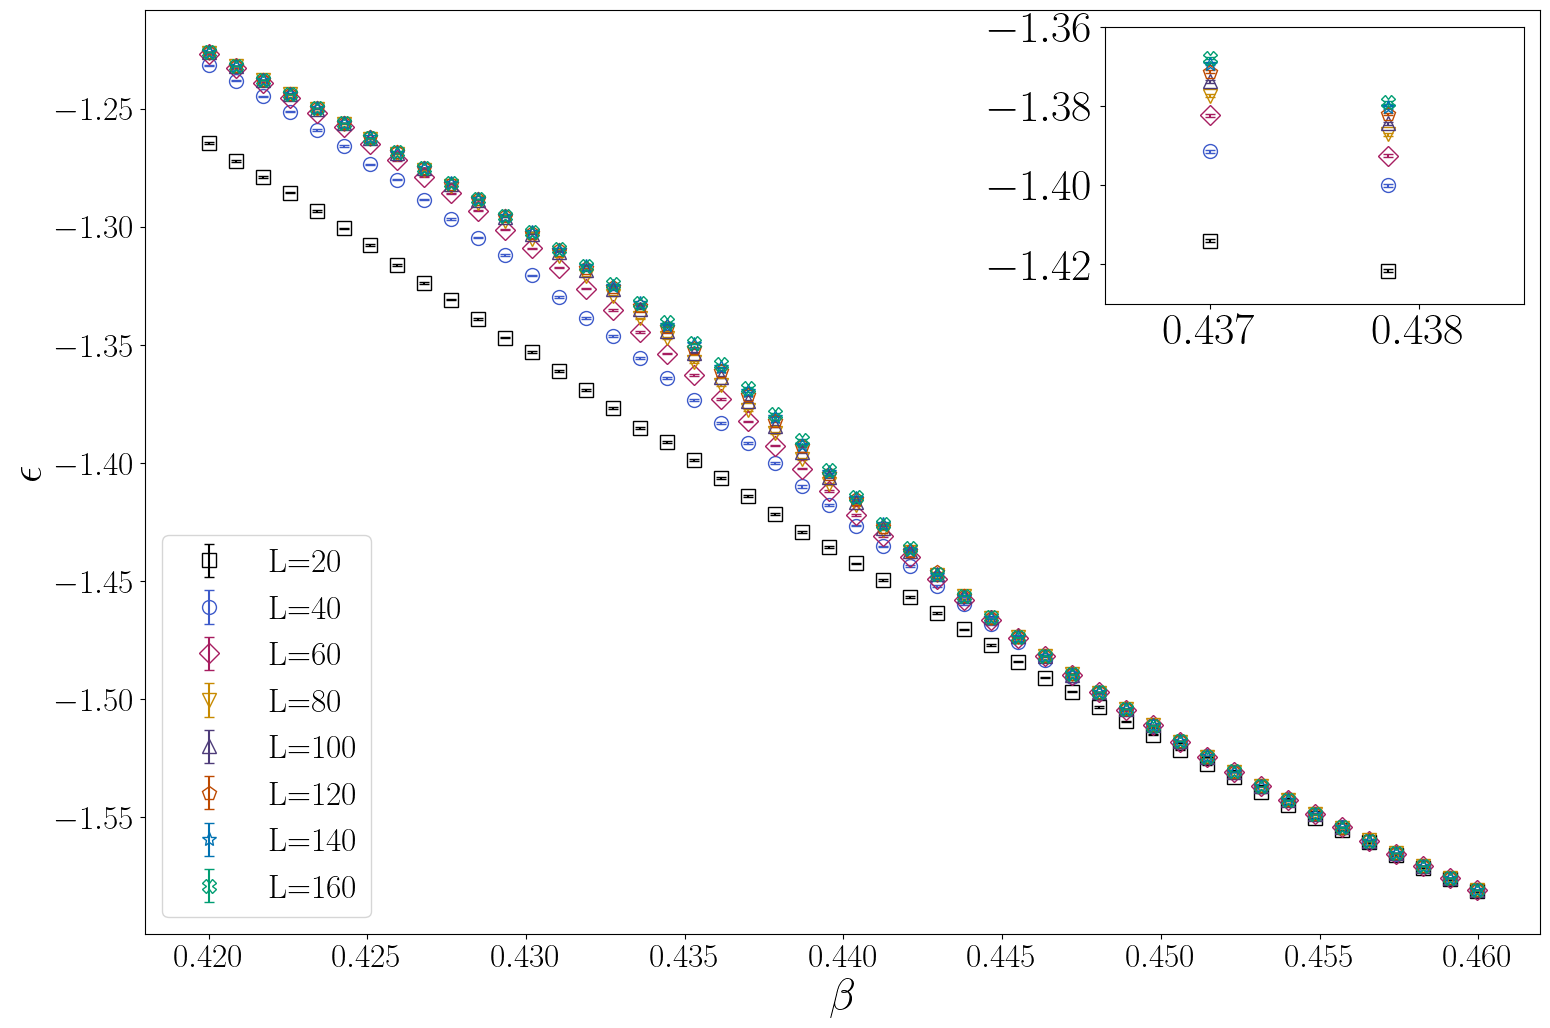

In [19]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(18,12))
ax = plt.gca()

inset = inset_axes(ax, width="30%", height="30%", loc='upper right')  # Inset axes
inset.set_xlim(0.4365, 0.4385)
inset.set_ylim(-1.43, -1.36)

for i, Ns in enumerate(Ns_lst):
    data = [
        np.load(f'{path}/L{Ns}/energy/energy_b{beta:.6f}.npy', allow_pickle=True)
        for beta in beta_lst
    ]

    x, y, d_y, b_y = map(list, zip(*data))
    ax.errorbar(x,y,d_y, **plot.data(i), label=f'L={Ns}')
    inset.errorbar(x, y, d_y, **plot.data(i))
    

ax.set_xlabel(r'$\beta$', fontsize=32)
ax.set_ylabel(r'$\epsilon$', fontsize=32)
ax.legend(loc='lower left')

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

plt.savefig(f"{path}/energy.png", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:

def get_chi(path, Ns, beta):
    x_m, m, d_m, b_m = np.load(f'{path}/L{Ns}/avgabsmag/avgabsmag_b{beta:.6f}.npy', allow_pickle=True)
    x_m2, m2, d_m2, b_m2 = np.load(f'{path}/L{Ns}/avgmag2/avgmag2_b{beta:.6f}.npy', allow_pickle=True)

    chi, d_chi = Ns**2*m2, Ns**2*d_m2
    chip = Ns**2*(m2-m**2)
    
    b_m=np.sum(b_m, axis=1)/len(b_m)
    b_m2=np.sum(b_m2, axis=1)/len(b_m2)
    
    b_chip = []
    for b_m_j, b_m2_j in zip(b_m, b_m2):
        b_chip.append(Ns**2*(b_m2_j-b_m_j**2))
    
    d_chip = np.std(b_chip, ddof=1)
    
    return x_m, chi, d_chi, chip, d_chip


In [ ]:

def plot_chi(path, Ns_lst, beta_lst):
    plt.figure(figsize = (18,12))
    for i, Ns in enumerate(Ns_lst):
        for beta in beta_lst:
            x, chi, d_chi, _, _ = get_chi(path, Ns, beta)
            label = f'L={Ns}' if beta == beta_lst[0] else None
            plt.errorbar(x, chi/1e3, d_chi/1e3, **plot.data(i), label=label)
    
    plt.legend()
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\chi/10^3$')
    plt.savefig(f"{path}/chi.png", bbox_inches='tight', dpi=300)
    plt.close()


In [ ]:
    
def plot_chip(path, Ns_lst, beta_lst):
    plt.figure(figsize = (18,12))
    for i, Ns in enumerate(Ns_lst):
        for beta in beta_lst:
            x, _, _, chip, d_chip = get_chi(path, Ns, beta)
            label = f'L={Ns}' if beta == beta_lst[0] else None
            plt.errorbar(x, chip/100, d_chip/100, **plot.data(i), label=label)
            
    plt.legend()
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\chi_p/10^2$')
    plt.savefig(f"{path}/chip.png", bbox_inches='tight', dpi=300)
    plt.close()    



In [ ]:
    
def get_heat(path, Ns, beta):
    x_e, e, d_e, b_e = np.load(f'{path}/L{Ns}/energy/energy_b{beta:.6f}.npy', allow_pickle=True)
    x_e2, e2, d_e2, b_e2 = np.load(f'{path}/L{Ns}/energy2/energy2_b{beta:.6f}.npy', allow_pickle=True)

    heat = Ns**2*(e2-e**2)
            
    b_e=np.sum(b_e, axis=1)/len(b_e)
    #b_e2=np.sum(b_e2, axis=1)/len(b_e2)
    
    b_heat = []
    for b_e_j, b_e2_j in zip(b_e, b_e2):
        b_heat.append(Ns**2*(b_e2_j-b_e_j**2))
    
    d_heat = np.std(b_heat, ddof=1)
    
    return x_e, heat, d_heat



In [ ]:
    
def plot_heat(path, Ns_lst, beta_lst):
    plt.figure(figsize = (18,12))
    for i, Ns in enumerate(Ns_lst):
        for beta in beta_lst:
            x, y, d_y = get_heat(path, Ns, beta)
            label = f'L={Ns}' if beta == beta_lst[0] else None
            plt.errorbar(x, y, d_y, **plot.data(i), label=label)
    plt.legend()
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$C$')
    plt.savefig(f"{path}/heat.png", bbox_inches='tight', dpi=300)
    plt.close()   



In [ ]:
    
def get_binder(path, Ns, beta):
    x_m2, m2, d_m2, b_m2 = np.load(f'{path}/L{Ns}/avgmag2/avgmag2_b{beta:.6f}.npy', allow_pickle=True)
    x_m4, m4, d_m4, b_m4 = np.load(f'{path}/L{Ns}/avgmag4/avgmag4_b{beta:.6f}.npy', allow_pickle=True)

    binder = m4/m2**2

    ## remove
    b_m2=np.sum(b_m2, axis=1)/len(b_m2)
    b_m4=np.sum(b_m4, axis=1)/len(b_m4)

    
    b_binder = []
    for b_m2_j, b_m4_j in zip(b_m2, b_m4):
        b_binder.append((b_m4_j/b_m2_j**2))
    
    d_binder = np.std(b_binder, ddof=1)
    
    return x_m2, binder, d_binder


In [ ]:
    
def plot_binder(path, Ns_lst, beta_lst):
    plt.figure(figsize = (18,12))
    for i, Ns in enumerate(Ns_lst):
        for beta in beta_lst:
            x, y, d_y = get_binder(path, Ns, beta)
            label = f'L={Ns}' if beta == beta_lst[0] else None
            plt.errorbar(x, y, d_y, **plot.data(i), label=label)
            
    plt.legend()
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$U$')
    plt.savefig(f"{path}/binder.png", bbox_inches='tight', dpi=300)
    plt.close()     


In [ ]:

## collapse plots
def plot_collapse_avgabsmag(path, Ns_lst, beta_lst):
    plt.figure(figsize=(18,12))
    for i, Ns in enumerate(Ns_lst):
        data = [
            np.load(f'{path}/L{Ns}/avgabsmag/avgabsmag_b{beta:.6f}.npy', allow_pickle=True)
            for beta in beta_lst
        ]

        x, y, d_y, _ = map(list, zip(*data))
        x , y, d_y= np.array(x), np.array(y), np.array(d_y)
        x = (x-criticals["beta_c"])*Ns**(1/criticals["nu"])
        y = y*Ns**(criticals["beta"]/criticals["nu"])
        d_y = d_y*Ns**(criticals["beta"]/criticals["nu"])
        plt.errorbar(x, y, d_y, **plot.data(i), label=f'L={Ns}')
    
    plt.legend()
    plt.xlabel(r'$(\beta-\beta_c)L^{1/\nu}$')
    plt.ylabel(r'$\langle |m| \rangle L^{\beta/\nu}$')
    plt.legend()
    plt.savefig(f"{path}/collapse_avgabsmag.png", bbox_inches='tight', dpi=300)



In [ ]:

def plot_collapse_chi(path, Ns_lst, beta_lst): 
    plt.figure(figsize = (18,12))
    for i, Ns in enumerate(Ns_lst):
        for beta in beta_lst:
            x, chi, d_chi, _, _ = get_chi(path, Ns, beta)
            
            x , chi, d_chi= np.array(x), np.array(chi), np.array(d_chi)

            x = (x-criticals["beta_c"])*Ns**(1/criticals["nu"])
            chi = chi/Ns**(criticals["gamma"]/criticals["nu"])
            d_chi = d_chi/Ns**(criticals["gamma"]/criticals["nu"])
            
            label = f'L={Ns}' if beta == beta_lst[0] else None
            plt.errorbar(x, chi/1e3, d_chi/1e3, **plot.data(i), label=label)
    plt.legend()
    plt.xlabel(r'$(\beta-\beta_c)L^{1/\nu}$')
    plt.ylabel(r'$\chi/L^{\gamma/\nu}$')
    plt.savefig(f"{path}/collapse_chi.png", bbox_inches='tight', dpi=300)
    plt.close() 



In [ ]:

def plot_collapse_chip(path, Ns_lst, beta_lst): 
    plt.figure(figsize = (18,12))
    for i, Ns in enumerate(Ns_lst):
        for beta in beta_lst:
            x, _, _, chip, d_chip = get_chi(path, Ns, beta)
            
            x, chip, d_chip = np.array(x), np.array(chip), np.array(d_chip)
            
            x = (x-criticals["beta_c"])*Ns**(1/criticals["nu"])
            chip = chip/Ns**(criticals["gamma"]/criticals["nu"])
            d_chip = d_chip/Ns**(criticals["gamma"]/criticals["nu"])

            label = f'L={Ns}' if beta == beta_lst[0] else None
            plt.errorbar(x, chip/100, d_chip/100, **plot.data(i), label=label)
            
    plt.legend()
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\chi_p/L^{\gamma/\nu}$')
    plt.savefig(f"{path}/collapse_chip.png", bbox_inches='tight', dpi=300)
    plt.close()    



In [ ]:

def plot_collapse_binder(path, Ns_lst, beta_lst):
    plt.figure(figsize = (18,12))
    for i, Ns in enumerate(Ns_lst):
        for beta in beta_lst:
            x, y, d_y = get_binder(path, Ns, beta)
            
            x = np.array(x)
            x = (x-criticals["beta_c"])*Ns**(1/criticals["nu"])
            
            label = f'L={Ns}' if beta == beta_lst[0] else None
            plt.errorbar(x, y, d_y, **plot.data(i), label=label)
        
    plt.xlabel(r'$(\beta-\beta_c)L^{1/\nu}$')
    plt.ylabel(r'$U$')
    plt.legend()
    plt.savefig(f"{path}/collapse_binder.png", bbox_inches='tight', dpi=300)
    plt.close()   